In [1]:
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Data Preprocessing

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
nursery = fetch_ucirepo(id=76)

# data (as pandas dataframes)
X = nursery.data.features
y = nursery.data.targets

In [4]:
# menampilkan 10 data fitur teratas
X.head(10)

,parents,has_nurs,form,children,housing,finance,social,health
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended
1,usual,proper,complete,1,convenient,convenient,nonprob,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority
5,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom
6,usual,proper,complete,1,convenient,convenient,problematic,recommended
7,usual,proper,complete,1,convenient,convenient,problematic,priority
8,usual,proper,complete,1,convenient,convenient,problematic,not_recom
9,usual,proper,complete,1,convenient,inconv,nonprob,recommended


In [5]:
# menampilkan 10 data target pertama
y.head(10)

,class
0,recommend
1,priority
2,not_recom
3,recommend
4,priority
5,not_recom
6,priority
7,priority
8,not_recom
9,very_recom


In [6]:
# jumlah data target tiap kelas
y.value_counts()

,count
class,
not_recom,4320
priority,4266
spec_prior,4044
very_recom,328
recommend,2


In [7]:
# menghapus baris data class 'recommend' karena datanya hanya 0.00015% dari dataset sehingga tidak mencukupi untuk proses training dan validasi model yang reliable
X = X[y['class'] != 'recommend']
y = y[y['class'] != 'recommend']
y.value_counts()

,count
class,
not_recom,4320
priority,4266
spec_prior,4044
very_recom,328


In [8]:
# kategori tiap fitur
for col in X.columns:
    print(f"{col}: {X[col].unique()} \n")

parents: ['usual' 'pretentious' 'great_pret'] 

has_nurs: ['proper' 'less_proper' 'improper' 'critical' 'very_crit'] 

form: ['complete' 'completed' 'incomplete' 'foster'] 

children: ['1' '2' '3' 'more'] 

housing: ['convenient' 'less_conv' 'critical'] 

finance: ['convenient' 'inconv'] 

social: ['nonprob' 'slightly_prob' 'problematic'] 

health: ['priority' 'not_recom' 'recommended'] 



In [9]:
X.isnull().sum()

,0
parents,0
has_nurs,0
form,0
children,0
housing,0
finance,0
social,0
health,0


In [10]:
y.isnull().sum()

,0
class,0


In [11]:
print(X.duplicated().sum())

0


In [12]:
# Label Encoding
parents_mapping = {'usual':0, 'pretentious':1, 'great_pret':2}
has_nurs_mapping = {'proper':0, 'less_proper':1, 'improper':2, 'critical':3, 'very_crit':4}
form_mapping = {'complete':0, 'completed':1, 'incomplete':2, 'foster':3}
children_mapping = {'1':0, '2':1, '3':2, 'more':3}
housing_mapping = {'convenient':0, 'less_conv':1, 'critical':2}
finance_mapping = {'convenient':0, 'inconv':1}
social_mapping = {'nonprob':0, 'slightly_prob':1, 'problematic':2}
health_mapping = {'recommended':0, 'priority':1, 'not_recom':2}
class_mapping = {
    'not_recom':0,
    'very_recom':1,
    'priority':2,
    'spec_prior':3
}

X['parents'] = X['parents'].map(parents_mapping)
X['has_nurs'] = X['has_nurs'].map(has_nurs_mapping)
X['form'] = X['form'].map(form_mapping)
X['children'] = X['children'].map(children_mapping)
X['housing'] = X['housing'].map(housing_mapping)
X['finance'] = X['finance'].map(finance_mapping)
X['social'] = X['social'].map(social_mapping)
X['health'] = X['health'].map(health_mapping)
y['class'] = y['class'].map(class_mapping)



<ipython-input-12-b7920e984b0c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['parents'] = X['parents'].map(parents_mapping)
<ipython-input-12-b7920e984b0c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['has_nurs'] = X['has_nurs'].map(has_nurs_mapping)
<ipython-input-12-b7920e984b0c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [13]:
# kategori tiap fitur
for col in X.columns:
    print(f"{col}: {X[col].unique()} \n")

parents: [0 1 2] 

has_nurs: [0 1 2 3 4] 

form: [0 1 2 3] 

children: [0 1 2 3] 

housing: [0 1 2] 

finance: [0 1] 

social: [0 1 2] 

health: [1 2 0] 



In [14]:
# split dulu
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [15]:
print("X_train :", X_train.shape)
print("X_val :", X_val.shape)
print("X_test :",X_test.shape)
print("y_train :",y_train.shape)
print("y_val :",y_val.shape)
print("y_test :",y_test.shape)

X_train : (7774, 8)
X_val : (2592, 8)
X_test : (2592, 8)
y_train : (7774, 1)
y_val : (2592, 1)
y_test : (2592, 1)


In [16]:
y_train.value_counts()

,count
class,
0,2639
2,2550
3,2387
1,198


In [17]:
# karena masih imbalance maka oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [18]:
print("X_train_sm :", X_train_sm.shape)
print("X_val :", X_val.shape)
print("X_test :",X_test.shape)
print("y_train_sm :",y_train_sm.shape)
print("y_val :",y_val.shape)
print("y_test :",y_test.shape)

X_train_sm : (10556, 8)
X_val : (2592, 8)
X_test : (2592, 8)
y_train_sm : (10556, 1)
y_val : (2592, 1)
y_test : (2592, 1)


In [19]:
y_train_sm.value_counts()

,count
class,
0,2639
1,2639
2,2639
3,2639


# Pembangunan Model Baseline

## Logistic Regression

In [20]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])
pipe_lr.fit(X_train_sm, y_train_sm)

y_pred_lr = pipe_lr.predict(X_val)

print(f"Accuracy Score:",accuracy_score(y_val, y_pred_lr))
print(f"Classification Report:\n",classification_report(y_val, y_pred_lr))
print(f"Confusion Matrix:\n",confusion_matrix(y_val, y_pred_lr))

Accuracy Score: 0.8908179012345679
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       0.43      0.85      0.57        67
           2       0.87      0.79      0.83       858
           3       0.88      0.89      0.88       828

    accuracy                           0.89      2592
   macro avg       0.79      0.88      0.82      2592
weighted avg       0.90      0.89      0.89      2592

Confusion Matrix:
 [[839   0   0   0]
 [  0  57  10   0]
 [  0  77 678 103]
 [  0   0  93 735]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## SVM

In [21]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42,probability=True))
])
pipe_svm.fit(X_train_sm, y_train_sm)

y_pred_svm = pipe_svm.predict(X_val)

print(f"Accuracy Score:",accuracy_score(y_val, y_pred_svm))
print(f"Classification Report:\n",classification_report(y_val, y_pred_svm))
print(f"Confusion Matrix:\n",confusion_matrix(y_val, y_pred_svm))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9772376543209876
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       0.88      0.97      0.92        67
           2       0.99      0.95      0.96       858
           3       0.96      0.99      0.97       828

    accuracy                           0.98      2592
   macro avg       0.95      0.98      0.96      2592
weighted avg       0.98      0.98      0.98      2592

Confusion Matrix:
 [[839   0   0   0]
 [  0  65   2   0]
 [  0   9 811  38]
 [  0   0  10 818]]


## MLP

In [22]:
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=42))
])
pipe_mlp.fit(X_train_sm, y_train_sm)

y_pred_mlp = pipe_mlp.predict(X_val)

print(f"Accuracy Score:",accuracy_score(y_val, y_pred_mlp))
print(f"Classification Report:\n",classification_report(y_val, y_pred_mlp))
print(f"Confusion Matrix:\n",confusion_matrix(y_val, y_pred_mlp))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9972993827160493
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       0.98      0.94      0.96        67
           2       0.99      1.00      1.00       858
           3       1.00      1.00      1.00       828

    accuracy                           1.00      2592
   macro avg       0.99      0.98      0.99      2592
weighted avg       1.00      1.00      1.00      2592

Confusion Matrix:
 [[839   0   0   0]
 [  0  63   4   0]
 [  0   1 857   0]
 [  0   0   2 826]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Eksplorasi Model

In [23]:
from sklearn.model_selection import GridSearchCV

## Logistic Regression

In [24]:
param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__solver': ['liblinear', 'saga'],
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter': [1000, 2000, 3000]
}

grid_search_lr = GridSearchCV(estimator=pipe_lr,
                              param_grid=param_grid_lr,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=1)

grid_search_lr.fit(X_train_sm,y_train_sm)

print("\n--- Hasil Hyperparameter Tuning Logistic Regression ---")
print("Parameter terbaik Logistic Regression:", grid_search_lr.best_params_)
print("Skor cross-validation terbaik Logistic Regression:", grid_search_lr.best_score_)
best_lr = grid_search_lr.best_estimator_
y_pred_lr_val = best_lr.predict(X_val)
print("Validation Set Accuracy (Logistic Regression):", accuracy_score(y_val, y_pred_lr_val))
print(f"Classification Report:\n",classification_report(y_val, y_pred_lr_val))
print(f"Confusion Matrix:\n",confusion_matrix(y_val, y_pred_lr_val))

Fitting 5 folds for each of 60 candidates, totalling 300 fits

--- Hasil Hyperparameter Tuning Logistic Regression ---
Parameter terbaik Logistic Regression: {'lr__C': 0.1, 'lr__max_iter': 1000, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
Skor cross-validation terbaik Logistic Regression: 0.9054562231744254
Validation Set Accuracy (Logistic Regression): 0.8904320987654321
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       0.42      0.87      0.56        67
           2       0.87      0.79      0.83       858
           3       0.88      0.89      0.88       828

    accuracy                           0.89      2592
   macro avg       0.79      0.89      0.82      2592
weighted avg       0.90      0.89      0.89      2592

Confusion Matrix:
 [[839   0   0   0]
 [  0  58   9   0]
 [  0  81 676 101]
 [  0   0  93 735]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## SVM

In [25]:
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search_svm = GridSearchCV(estimator=pipe_svm,
                               param_grid=param_grid_svm,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)

grid_search_svm.fit(X_train_sm, y_train_sm)

print("\n--- Hasil Hyperparameter Tuning SVM ---")
print("Parameter terbaik SVM:", grid_search_svm.best_params_)
print("Skor cross-validation terbaik SVM:", grid_search_svm.best_score_)
best_svm = grid_search_svm.best_estimator_
y_pred_svm_val = best_svm.predict(X_val)
print("Validation Set Accuracy (SVM):", accuracy_score(y_val, y_pred_svm_val))
print(f"Classification Report:\n",classification_report(y_val, y_pred_svm_val))
print(f"Confusion Matrix:\n",confusion_matrix(y_val, y_pred_svm_val))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



--- Hasil Hyperparameter Tuning SVM ---
Parameter terbaik SVM: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Skor cross-validation terbaik SVM: 0.9954529305370139
Validation Set Accuracy (SVM): 0.998070987654321
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00       858
           3       1.00      1.00      1.00       828

    accuracy                           1.00      2592
   macro avg       1.00      1.00      1.00      2592
weighted avg       1.00      1.00      1.00      2592

Confusion Matrix:
 [[839   0   0   0]
 [  0  67   0   0]
 [  0   0 856   2]
 [  0   0   3 825]]


## MLP

In [26]:
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50,25)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__max_iter': [200, 300, 400]
}

grid_search_mlp = GridSearchCV(estimator=pipe_mlp,
                               param_grid=param_grid_mlp,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)

grid_search_mlp.fit(X_train_sm, y_train_sm)

print("\n--- Hasil Hyperparameter Tuning MLP ---")
print("Parameter terbaik MLP:", grid_search_mlp.best_params_)
print("Skor cross-validation terbaik MLP:", grid_search_mlp.best_score_)
best_mlp = grid_search_mlp.best_estimator_
y_pred_mlp_val = best_mlp.predict(X_val)
print("Validation Set Accuracy (MLP):", accuracy_score(y_val, y_pred_mlp_val))
print(f"Classification Report:\n",classification_report(y_val, y_pred_mlp_val))
print(f"Confusion Matrix:\n",confusion_matrix(y_val, y_pred_mlp_val))


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



--- Hasil Hyperparameter Tuning MLP ---
Parameter terbaik MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50, 25), 'mlp__learning_rate_init': 0.01, 'mlp__max_iter': 200}
Skor cross-validation terbaik MLP: 0.9995262908574135
Validation Set Accuracy (MLP): 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00       858
           3       1.00      1.00      1.00       828

    accuracy                           1.00      2592
   macro avg       1.00      1.00      1.00      2592
weighted avg       1.00      1.00      1.00      2592

Confusion Matrix:
 [[839   0   0   0]
 [  0  67   0   0]
 [  0   0 858   0]
 [  0   0   0 828]]


# Evaluasi

In [27]:
models = {"Logistic Regression": best_lr, "SVM": best_svm, "MLP": best_mlp}

for name, model in models.items():
    y_pred = model.predict(X_test)

    print(f"\n--- {name} ---")
    print(f"Akurasi Keseluruhan: {accuracy_score(y_test, y_pred):.4f}")
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
Akurasi Keseluruhan: 0.8970

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       0.40      0.87      0.55        63
           2       0.88      0.80      0.84       858
           3       0.89      0.90      0.89       829

    accuracy                           0.90      2592
   macro avg       0.79      0.89      0.82      2592
weighted avg       0.91      0.90      0.90      2592


--- SVM ---
Akurasi Keseluruhan: 0.9981

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       0.98      1.00      0.99        63
           2       1.00      1.00      1.00       858
           3       1.00      1.00      1.00       829

    accuracy                           1.00      2592
   macro avg       0.99      1.00      1.00      2592
weighted avg       1.00      1.00      1.00


--- Confusion Matrix: Logistic Regression ---
[[842   0   0   0]
 [  0  55   8   0]
 [  0  82 683  93]
 [  0   0  84 745]]

--- Confusion Matrix: SVM ---
[[842   0   0   0]
 [  0  63   0   0]
 [  0   1 855   2]
 [  0   0   2 827]]

--- Confusion Matrix: MLP ---
[[842   0   0   0]
 [  0  63   0   0]
 [  0   0 857   1]
 [  0   0   0 829]]


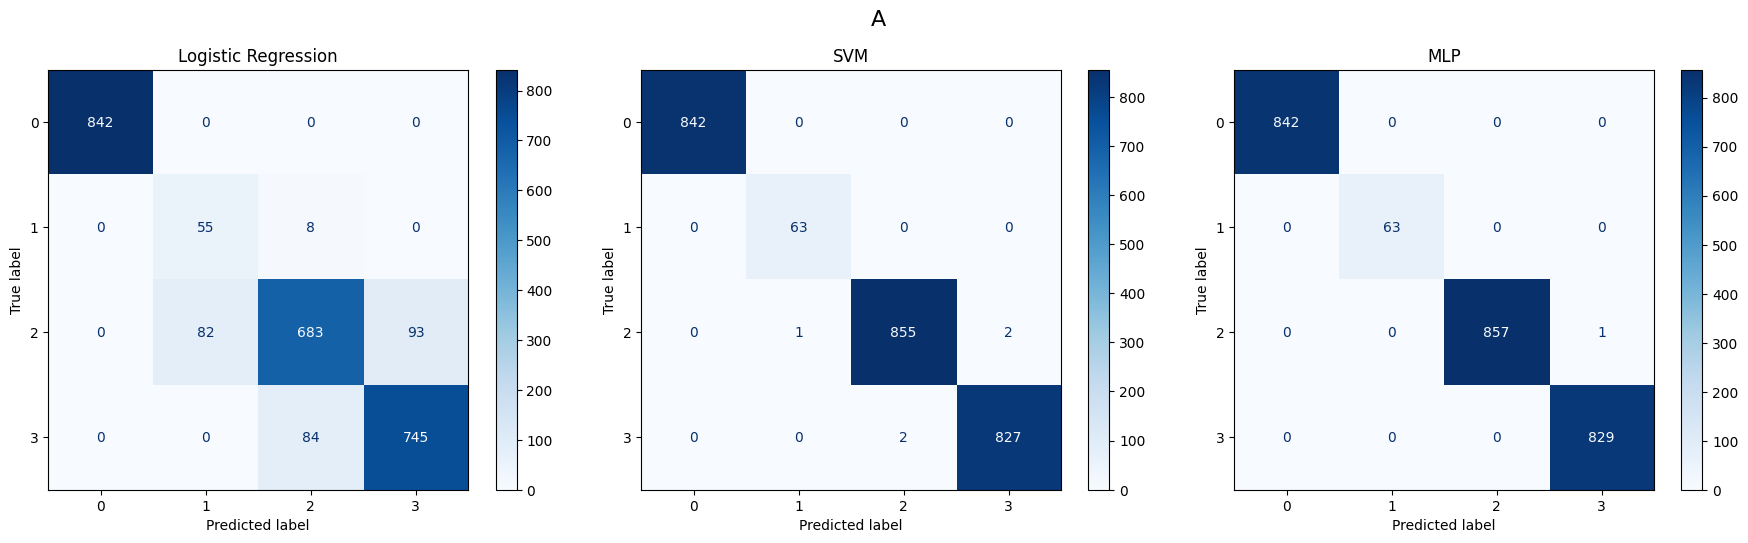

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(6 * 3, 5))

i = 0
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    print(f"\n--- Confusion Matrix: {name} ---")
    print(cm)

    disp.plot(ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{name}')
    i += 1

plt.suptitle('A', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Dataset Anda memiliki 4 kelas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
AUC Macro - Logistic Regression: 0.983
AUC Macro - SVM: 1.000
AUC Macro - MLP: 1.000


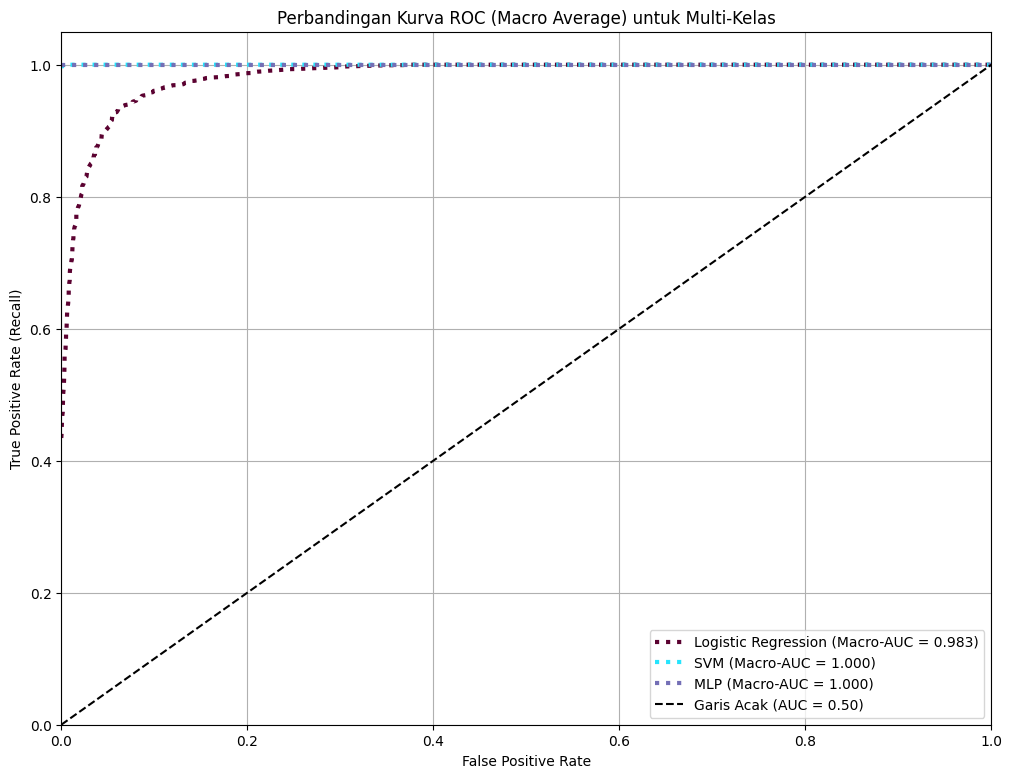

In [29]:
classes = np.unique(y_test)
n_classes = len(classes)
print(f"Dataset Anda memiliki {n_classes} kelas: {list(classes)}")

y_test_binarized = label_binarize(y_test, classes=classes)

plt.figure(figsize=(12, 9))

colors_rgb = [np.random.rand(3,) for _ in range(n_classes)]

roc_auc_scores = {} # Simpan skor AUC (Macro)

for (name, model), color in zip(models.items(), colors_rgb):
    y_score = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        # Pastikan jumlah kolom probabilitas = jumlah kelas
        if y_score.shape[1] != n_classes:
            print(f"Peringatan: {name} predict_proba tidak menghasilkan {n_classes} kolom. Skipping.")
            continue
    else:
        print(f"Skipping ROC untuk {name} karena tidak ada predict_proba(). (Pastikan SVM pakai probability=True)")
        continue

    # Menghitung ROC dan AUC untuk setiap kelas (OvR)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Meenghitung Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    roc_auc_scores[name] = roc_auc["macro"]

    # Plot Macro-average ROC
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f'{name} (Macro-AUC = {roc_auc["macro"]:.3f})',
        color=color,
        linestyle=':',
        linewidth=3,
    )

    print(f"AUC Macro - {name}: {roc_auc['macro']:.3f}")


# Plot garis acak
plt.plot([0, 1], [0, 1], 'k--', label='Garis Acak (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Perbandingan Kurva ROC (Macro Average) untuk Multi-Kelas')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<ipython-input-30-fb0534ed46df>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC Score', y='Model', data=auc_df, palette='viridis')


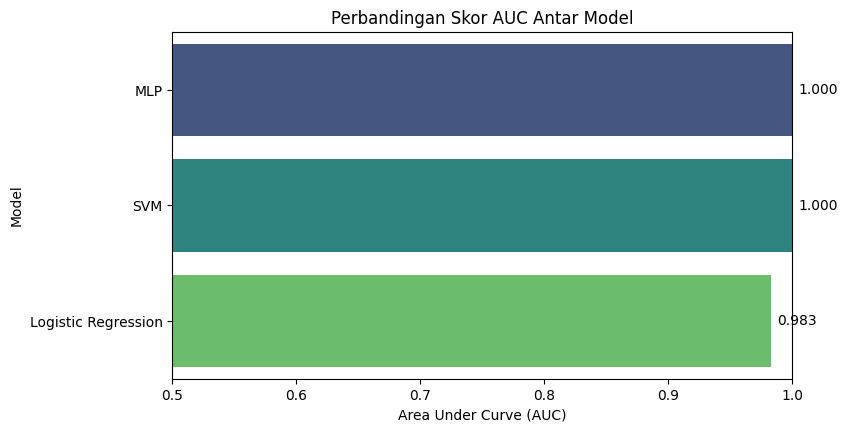

In [30]:
auc_df = pd.DataFrame(list(roc_auc_scores.items()), columns=['Model', 'AUC Score'])
auc_df = auc_df.sort_values(by='AUC Score', ascending=False)

plt.figure(figsize=(8, max(4, 3 * 1.5))) # Ukuran dinamis
sns.barplot(x='AUC Score', y='Model', data=auc_df, palette='viridis')
plt.title('Perbandingan Skor AUC Antar Model')
plt.xlabel('Area Under Curve (AUC)')
plt.ylabel('Model')
plt.xlim(min(0.5, auc_df['AUC Score'].min() - 0.05), 1.0) # Batas x dinamis

for index, value in enumerate(auc_df['AUC Score']):
    plt.text(value + 0.005, index, f'{value:.3f}', va='center') # Tampilkan nilai

plt.show()

In [31]:
!pip install joblib

In [34]:
import joblib
joblib.dump(best_mlp, 'best_mlp_model.pkl')

['best_mlp_model.pkl']